# Synthetic example
> In what cases are mixture embeddings substantially better than their alternatives?

## Prelimaries

In [71]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import ete3

from tqdm import tqdm

from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperbolic import Hyperbolic

from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Global variables

N_OTUS = 1000
N_SAMPLES = 20

# GEOMETRY = "hyperbolic"
GEOMETRY = "euclidean"
N_DIM = 128
# N_DIM = 16


My first idea is modeling functional redundancy at a phylogenetic level.

To simulate functional redundancy, we will draw reads as follows:
X (read probabilities) ~ Dirichlet(alpha)
Y (read counts) ~ NegativeBinomial(1, X)

Then we will allow for functional redundancy by allowing read probabilities to mix across closely related species:
If d(OTU_1, OTU_2) < epsilon, and random() < p, then allow X1 and X2 to switch counts:
    Y_1 <-> Y_2

In [7]:
# Load embeddings

# Embedding paths
embed_path = f"~/DATA/otu_embeddings/embeddings_{GEOMETRY}_{N_DIM}.csv"

# Load embeddings
embed = pd.read_csv(embed_path, index_col=0)

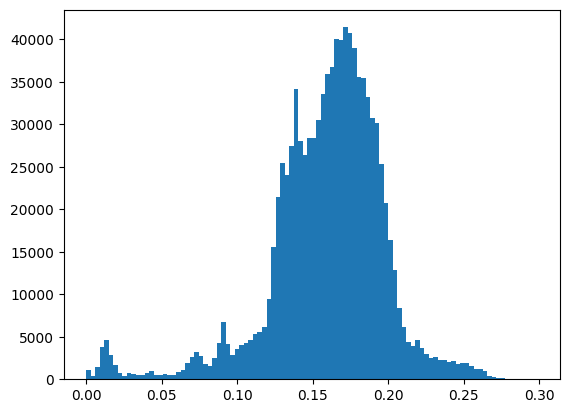

In [8]:
# Distance matrix

if GEOMETRY == "euclidean":
    manifold = Euclidean(N_DIM)
elif GEOMETRY == "hyperbolic":
    manifold = Hyperbolic(N_DIM, point_type="ball") # Poincare ball

# Distance matrix
embed_sample_idx = np.random.choice(embed.index, size=N_OTUS, replace=False)
embed_sample = embed.loc[embed_sample_idx]
dists = squareform(pdist(embed_sample, metric=manifold._metric.dist))

plt.hist(dists.flatten(), bins=100)
plt.show()

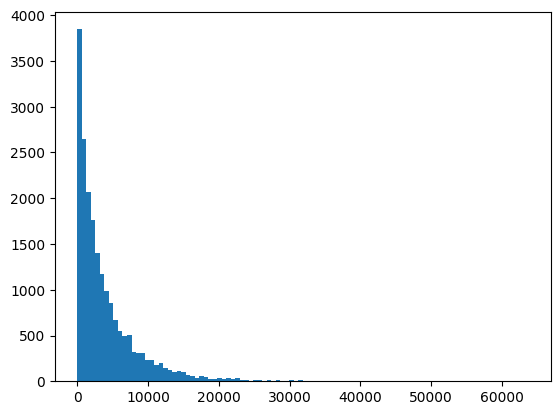

In [9]:
# Draw reads

def draw_reads(
    distance_matrix, 
    n_samples, 
    mean=None,
    density=0.2, 
    poisson_multiplier=1e6, 
    switch_prob=0.01,
    normalize_dists=True
):
    n = distance_matrix.shape[0]
    m = np.max(distance_matrix)
    if normalize_dists:
        distance_matrix = distance_matrix / m

    if mean is None:
        mean = np.ones(n)

    X = np.random.dirichlet(mean)
    S = np.random.binomial(n_samples, density, size=(n_samples, n))
    Y = np.random.poisson(X[None, :] * S * poisson_multiplier)

    for sam in range(n_samples):
        n_swaps = 0
        for i in range(n):
            for j in range(i+1, n): # Upper triangle
                # Randomly move reads from i to j,
                # Probability inversely proportional to distance
                # if np.random.rand() < switch_prob:
                if np.random.rand() < distance_matrix[i, j] ** 2 * switch_prob:
                    # i <-> j swap
                    Y[sam, i], Y[sam, j] = Y[sam, j], Y[sam, i]
                    n_swaps += 1
        # print(sam, n_swaps)
    return X, S, Y


X, S, Y = draw_reads(distance_matrix=dists, n_samples=N_SAMPLES)

plt.hist(Y.flatten(), bins=100)
plt.show()

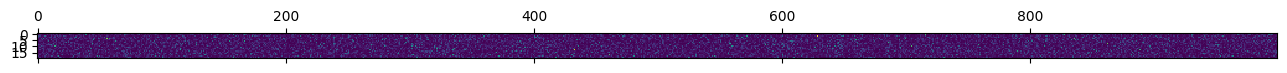

In [18]:
# Turn Y into an OTU table

otu_table = pd.DataFrame(
    Y, columns=embed_sample_idx, index=range(N_SAMPLES)
)
otu_table.index.name = "sample_id"
otu_table.columns.name = "otu_id"
otu_table = otu_table / otu_table.sum(axis=1).values[:, None] # Normalize
otu_table.head()

plt.matshow(otu_table)

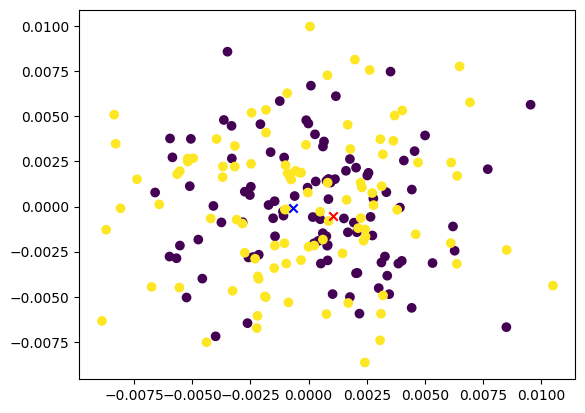

In [67]:
# Generate some samples

def get_data(n_samples):
    # Get two meaningfully different means
    corrs = 1 - dists / np.max(dists)
    # mean1 = np.abs(np.random.multivariate_normal(np.zeros(N_OTUS), corrs))
    # mean1 = np.abs(np.random.multivariate_normal(np.zeros(N_OTUS), np.eye(N_OTUS)))

    # mean2 = np.abs(np.random.multivariate_normal(np.zeros(N_OTUS), corrs))
    # mean2 = np.abs(np.random.multivariate_normal(np.zeros(N_OTUS), np.eye(N_OTUS)))

    mean1 = np.ones(N_OTUS)
    mean1[np.random.choice(N_OTUS, size=100)] += 1
    mean1 = np.abs(np.random.multivariate_normal(mean1, np.eye(N_OTUS)))

    mean2 = np.ones(N_OTUS)
    mean2[np.random.choice(N_OTUS, size=100)] += 1
    mean2 = np.abs(np.random.multivariate_normal(mean2, np.eye(N_OTUS)))

    # Draw reads
    _, _, Y1 = draw_reads(distance_matrix=dists, mean=mean1, n_samples=n_samples)
    _, _, Y2 = draw_reads(distance_matrix=dists, mean=mean2, n_samples=n_samples)

    # Get combined data
    # X = np.concatenate([X1, X2])
    # S = np.concatenate([S1, S2])
    Y = np.concatenate([Y1, Y2])
    labels = np.concatenate([np.zeros(100), np.ones(100)])

    # Normalize
    Y = Y / Y.sum(axis=1)[:, None]
    mean1 = mean1 / np.sum(mean1)
    mean2 = mean2 / np.sum(mean2)

    return Y, labels, mean1, mean2

def plot_pca(data, labels, mean1, mean2):
    # Scatterplot PCA
    pca = PCA(n_components=2)
    Y_pca = pca.fit_transform(data)
    m1_pca = pca.transform(mean1.reshape(1, -1))
    m2_pca = pca.transform(mean2.reshape(1, -1))
    plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=labels)
    plt.scatter(m1_pca[:, 0], m1_pca[:, 1], c="red", marker="x")
    plt.scatter(m2_pca[:, 0], m2_pca[:, 1], c="blue", marker="x")
    plt.show()

Y, labels, mean1, mean2 = get_data(n_samples=100)
plot_pca(Y, labels, mean1, mean2)

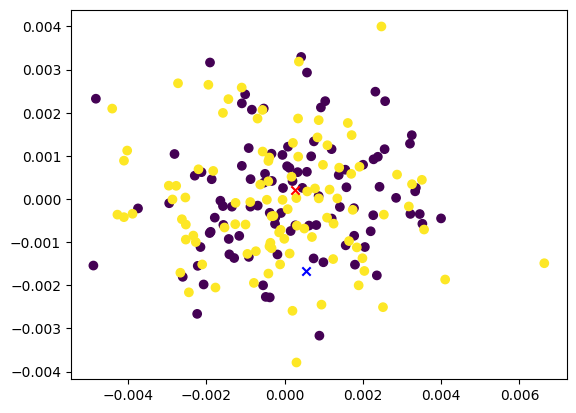

In [68]:
Y_embed = Y @ embed_sample.values
mean1_embed = mean1 @ embed_sample.values
mean2_embed = mean2 @ embed_sample.values

plot_pca(Y_embed, labels, mean1_embed, mean2_embed)

# # Scatterplot PCA
# pca = PCA(n_components=2)
# Y_embed_pca = pca.fit_transform(Y_embed)
# m1_embed_pca = pca.transform(mean1.reshape(1, -1) @ embed_sample.values)
# m2_embed_pca = pca.transform(mean2.reshape(1, -1) @ embed_sample.values)
# plt.scatter(Y_embed_pca[:, 0], Y_embed_pca[:, 1], c=labels)
# plt.scatter(m1_embed_pca[:, 0], m1_embed_pca[:, 1], c="red", marker="x")
# plt.scatter(m2_embed_pca[:, 0], m2_embed_pca[:, 1], c="blue", marker="x")

In [65]:
def cluster(data, n_clusters=2, geometry="euclidean", labels=None):
    ndim = data.shape[1]
    if geometry == "euclidean":
        manifold = Euclidean(ndim)
    elif geometry == "hyperbolic":
        manifold = Hyperbolic(ndim, point_type="ball")
    else:
        raise ValueError("Unknown geometry")

    pairwise_dists = squareform(pdist(data, metric=manifold._metric.dist))
    
    clusters = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric="precomputed",
        linkage="average"
    ).fit(pairwise_dists)

    if labels is not None:
        print("ARI:", adjusted_rand_score(labels, clusters.labels_))
        print("Accuracy:", accuracy_score(labels, clusters.labels_))
    return pairwise_dists, clusters.labels_

# Cluster both ways:
sample_dists, predicted_labels = cluster(Y, labels=labels)
print(predicted_labels)
print()

sample_dists_embed, predicted_labels_embed = cluster(Y_embed, labels=labels)
print(predicted_labels_embed)

ARI: 0.0
Accuracy: 0.505
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

ARI: 0.001206505477534868
Accuracy: 0.52
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [72]:
def experiment():
    Y, labels, _, _, = get_data(n_samples=100)
    Y_embed = Y @ embed_sample.values

    # Cluster both ways:
    _, predicted_labels = cluster(Y, labels=labels)
    _, predicted_labels_embed = cluster(Y_embed, labels=labels)

    return (
        accuracy_score(labels, predicted_labels), 
        accuracy_score(labels, predicted_labels_embed)
    )

acc_raw = []
acc_embed = []
for _ in tqdm(range(100)):
    acc_raw_, acc_embed_ = experiment()
    acc_raw.append(acc_raw_)
    acc_embed.append(acc_embed_)

  1%|          | 1/100 [00:47<1:17:54, 47.21s/it]

ARI: 0.0
Accuracy: 0.495
ARI: -0.0003901408981787559
Accuracy: 0.505


  2%|▏         | 2/100 [01:34<1:16:55, 47.10s/it]

ARI: 0.0
Accuracy: 0.495
ARI: 0.0006031942149653491
Accuracy: 0.485


  3%|▎         | 3/100 [02:21<1:15:56, 46.98s/it]

ARI: 0.0
Accuracy: 0.505
ARI: 0.0
Accuracy: 0.505


  4%|▍         | 4/100 [03:08<1:15:17, 47.06s/it]

ARI: 0.0
Accuracy: 0.505
ARI: 0.0
Accuracy: 0.495


  5%|▌         | 5/100 [03:55<1:14:27, 47.02s/it]

ARI: 0.0
Accuracy: 0.505
ARI: -0.0003941251226613902
Accuracy: 0.5


  6%|▌         | 6/100 [04:42<1:13:34, 46.96s/it]

ARI: 0.0
Accuracy: 0.505
ARI: -0.00019704344355534734
Accuracy: 0.505


  7%|▋         | 7/100 [05:29<1:12:47, 46.97s/it]

ARI: 0.00020104503207673486
Accuracy: 0.51
ARI: -0.0007644794674394616
Accuracy: 0.495


  8%|▊         | 8/100 [06:15<1:11:59, 46.95s/it]

ARI: 0.0
Accuracy: 0.505
ARI: -0.00019704344355534734
Accuracy: 0.505


  9%|▉         | 9/100 [07:02<1:11:11, 46.94s/it]

ARI: 0.00020104503207673486
Accuracy: 0.51
ARI: -0.00019704344355534734
Accuracy: 0.495


  9%|▉         | 9/100 [07:09<1:12:25, 47.75s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/phil/miniconda3/envs/mixture/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1799861/3533308912.py", line 17, in <module>
    acc_raw_, acc_embed_ = experiment()
                           ^^^^^^^^^^^^
  File "/tmp/ipykernel_1799861/3533308912.py", line 2, in experiment
    Y, labels, _, _, = get_data(n_samples=100)
                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1799861/640975267.py", line 21, in get_data
    _, _, Y1 = draw_reads(distance_matrix=dists, mean=mean1, n_samples=n_samples)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1799861/2521520809.py", line -1, in draw_reads
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/phil/miniconda3/envs/mixture/li